In [2]:
#导入库
import numpy as np
import pandas as pd
import datetime as dt
import plotly.offline as py
import plotly.graph_objs as go
import math as m
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Bidirectional
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from plotly.subplots import make_subplots  

- This data was collected using GreenEnergy - Storm Glass API for latitude and longitude at: lat, lng = -6.168371, -35.096696

In [53]:
#导入数据
data = pd.read_csv("../input/tibau-wind-speed/data_tibau.csv", names=['time', 'velocity', 'direction'])
data

,time,velocity,direction
0,2020-03-12 12:00:00,6.78,90.02
1,2020-03-12 13:00:00,6.78,90.02
2,2020-03-12 14:00:00,6.78,90.02
3,2020-03-12 15:00:00,6.78,90.02
4,2020-03-12 16:00:00,6.78,90.02
...,...,...,...
10676,2021-05-31 08:00:00,3.24,90.08
10677,2021-05-31 09:00:00,3.28,90.08
10678,2021-05-31 10:00:00,3.48,90.08
10679,2021-05-31 11:00:00,3.68,90.07


In [54]:
#数据格式转换
data['time'] = pd.to_datetime(data['time'], format='%Y-%m-%d %H:%M:%S')
data['year'] = data['time'].dt.strftime("%Y")


In [55]:
data

,time,velocity,direction,year
0,2020-03-12 12:00:00,6.78,90.02,2020
1,2020-03-12 13:00:00,6.78,90.02,2020
2,2020-03-12 14:00:00,6.78,90.02,2020
3,2020-03-12 15:00:00,6.78,90.02,2020
4,2020-03-12 16:00:00,6.78,90.02,2020
...,...,...,...,...
10676,2021-05-31 08:00:00,3.24,90.08,2021
10677,2021-05-31 09:00:00,3.28,90.08,2021
10678,2021-05-31 10:00:00,3.48,90.08,2021
10679,2021-05-31 11:00:00,3.68,90.07,2021


In [56]:
data[['velocity', 'year']].groupby(by='year').mean()

,velocity
year,
2020,4.959928
2021,4.912079


In [57]:
mean_velocity = data[['velocity', 'year']].groupby(by='year').mean()
mean_velocity

,velocity
year,
2020,4.959928
2021,4.912079


In [58]:
#归一化处理
vel = list(data['velocity'])
scaled_velocity = list()

vel_min = data['velocity'].min()
vel_max = data['velocity'].max()

for i in vel:
    scaled_velocity.append((i - vel_min)/(vel_max - vel_min))

data['velocity'] = scaled_velocity 



In [59]:
#训练集
velocity_train = np.array(data['velocity'][0:9948])
velocity_train.shape

(9948,)

In [60]:
#测试集
velocity_test = np.array(data['velocity'][9941:])
velocity_test.shape  ## Divided the data from before and after may, 2021

(740,)

In [61]:
#滑动窗口
def split_data(sequence, n_steps):
    X, Y = list(), list()
    for i in range(len(sequence)):
        initial = i
        end = i + n_steps
        if end > len(sequence)-1:
            break
        x_seq = sequence[initial:end]
        y_seq = sequence[end]
        X.append(x_seq)
        Y.append(y_seq)
    return np.array(X), np.array(Y)


In [62]:
# 步长设置
n_steps = 7
X, y = split_data(velocity_train, n_steps)

In [63]:
# 划分训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)


In [64]:
# 数据重塑
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
X_test, y_test = split_data(velocity_test, n_steps)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [65]:
# 双向 RNN 构建
model = Sequential([
    Bidirectional(SimpleRNN(50, activation='relu'), input_shape=(n_steps, n_features)),
    Dense(1)
])

In [66]:
# 优化器和损失函数
model.compile(optimizer='adam', loss='mse')

In [67]:
# 早停
early_stopping = EarlyStopping(min_delta=0.00005, patience=50)


In [68]:
# 调参
history = model.fit(X_train, y_train, epochs=200, validation_data=(X_val, y_val), verbose=2, callbacks=[early_stopping])

Epoch 1/200
280/280 - 3s - loss: 0.0036 - val_loss: 0.0011
Epoch 2/200
280/280 - 1s - loss: 7.2990e-04 - val_loss: 5.6380e-04
Epoch 3/200
280/280 - 1s - loss: 6.5385e-04 - val_loss: 5.3785e-04
Epoch 4/200
280/280 - 1s - loss: 6.1502e-04 - val_loss: 5.5435e-04
Epoch 5/200
280/280 - 1s - loss: 6.0448e-04 - val_loss: 5.4768e-04
Epoch 6/200
280/280 - 1s - loss: 6.0012e-04 - val_loss: 5.3325e-04
Epoch 7/200
280/280 - 1s - loss: 5.8999e-04 - val_loss: 6.4247e-04
Epoch 8/200
280/280 - 1s - loss: 6.0238e-04 - val_loss: 5.0710e-04
Epoch 9/200
280/280 - 1s - loss: 5.8886e-04 - val_loss: 5.1076e-04
Epoch 10/200
280/280 - 1s - loss: 5.9755e-04 - val_loss: 6.1658e-04
Epoch 11/200
280/280 - 1s - loss: 5.6615e-04 - val_loss: 5.1761e-04
Epoch 12/200
280/280 - 1s - loss: 5.6597e-04 - val_loss: 5.0508e-04
Epoch 13/200
280/280 - 1s - loss: 6.0431e-04 - val_loss: 4.9358e-04
Epoch 14/200
280/280 - 1s - loss: 5.5907e-04 - val_loss: 5.0684e-04
Epoch 15/200
280/280 - 1s - loss: 5.5102e-04 - val_loss: 6.2148e-

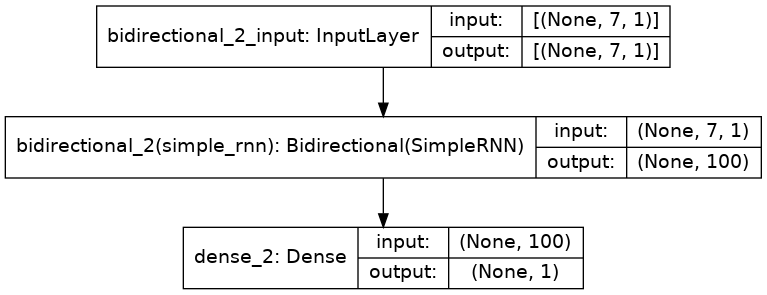

In [69]:
plot_model(model, to_file='bidir_rnn_model.png', show_shapes=True, show_layer_names=True)

In [70]:
# 预测
train_predictions = model.predict(X_train)
val_predictions = model.predict(X_val)
test_predictions = model.predict(X_test)

# 计算误差指标
def calculate_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    non_zero_actual = actual != 0
    mape = np.mean(np.abs((actual[non_zero_actual] - predicted[non_zero_actual]) / actual[non_zero_actual])) * 100
    return mae, rmse, mape

# 训练集误差
train_mae, train_rmse, train_mape = calculate_metrics(y_train, train_predictions)

# 验证集误差
val_mae, val_rmse, val_mape = calculate_metrics(y_val, val_predictions)

# 测试集误差
test_mae, test_rmse, test_mape = calculate_metrics(y_test, test_predictions)

# 打印误差指标
print(f"训练集 MAE: {train_mae:.4f}, RMSE: {train_rmse:.4f}, MAPE: {train_mape:.4f}")
print(f"验证集 MAE: {val_mae:.4f}, RMSE: {val_rmse:.4f}, MAPE: {val_mape:.4f}")
print(f"测试集 MAE: {test_mae:.4f}, RMSE: {test_rmse:.4f}, MAPE: {test_mape:.4f}")

训练集 MAE: 0.0126, RMSE: 0.0211, MAPE: 80.4177
验证集 MAE: 0.0126, RMSE: 0.0216, MAPE: 118.8072
测试集 MAE: 0.0140, RMSE: 0.0229, MAPE: 178.8940


In [71]:
# 反归一化
rescaled_train_predictions = train_predictions * (vel_max - vel_min) + vel_min
rescaled_train_actual = y_train * (vel_max - vel_min) + vel_min
rescaled_val_predictions = val_predictions * (vel_max - vel_min) + vel_min
rescaled_val_actual = y_val * (vel_max - vel_min) + vel_min
rescaled_test_predictions = test_predictions * (vel_max - vel_min) + vel_min
rescaled_test_actual = y_test * (vel_max - vel_min) + vel_min

# 绘制预测结果
fig = make_subplots(rows=3, cols=1, subplot_titles=('Close Predictions on Train Data', 'Close Predictions on Validation Data', 'Close Predictions on Test Data'))

fig.add_trace(go.Scatter(x=np.arange(len(rescaled_train_actual)), y=rescaled_train_actual, mode='lines', name='Train Actual', opacity=0.9), row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(len(rescaled_train_predictions)), y=rescaled_train_predictions, mode='lines', name='Train Predicted', opacity=0.6), row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(rescaled_val_actual)), y=rescaled_val_actual, mode='lines', name='Validation Actual', opacity=0.9), row=2, col=1)
fig.add_trace(go.Scatter(x=np.arange(len(rescaled_val_predictions)), y=rescaled_val_predictions, mode='lines', name='Validation Predicted', opacity=0.6), row=2, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(rescaled_test_actual)), y=rescaled_test_actual, mode='lines', name='Test Actual', opacity=0.9), row=3, col=1)
fig.add_trace(go.Scatter(x=np.arange(len(rescaled_test_predictions)), y=rescaled_test_predictions, mode='lines', name='Test Predicted', opacity=0.6), row=3, col=1)

fig.update_layout(title='Close Predictions on Train, Validation, and Test Data', template='plotly_dark')
fig.show()

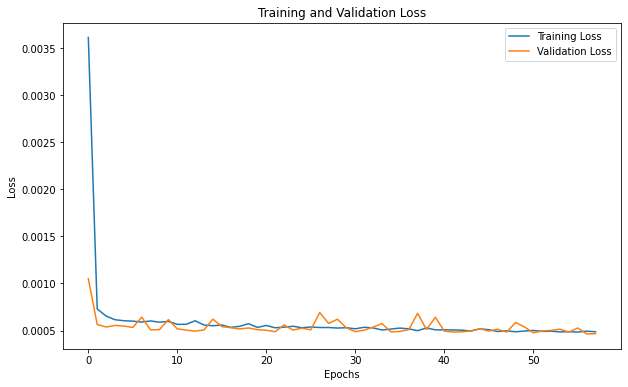

In [72]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

 -------------------------------------------------------------------------------------------------------------- 

## Great results!

 ----------------------------------------------------------------------------